In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import pyBigWig
from pyBioInfo.IO.File import GtfFile, GtfTranscriptBuilder, GtfGeneBuilder, FastaFile

In [2]:
f_gtf_ncbi = "../../common/ncbi_Sdu_1.0/GCF_002260705.1_Sdu_1.0_genomic.clean.sorted.gtf.gz"
f_gtf_ensembl = "../../common/ensembl_Sdu_1.0/Seriola_dumerili.Sdu_1.0.103.converted.clean.sorted.gtf.gz"
f_gtf_ngs = "../../1_analysis_of_rna_seq/results/assembly/stringtie/merged_all_samples.sorted.gtf.gz"
f_gtf_tgs = "../../2_analysis_of_iso_seq/results/assembly/tama/filtered_internal_primer/all_samples.mp4.sorted.gtf.gz"
f_gtf_asm = "../../3_integrate_isoforms/results/assembly/asm.final.sorted.gtf.gz"

f_fasta = "../../common/ncbi_Sdu_1.0/GCF_002260705.1_Sdu_1.0_genomic.fa"

# Nucleotide content

In [10]:
def load_polyA_content(f_gtf, f_fasta):
    with GtfFile(f_gtf) as f:
        transcripts = list(GtfTranscriptBuilder(f))
    seqs = []
    with FastaFile(f_fasta) as fasta:
        for transcript in transcripts:
            if len(transcript) < 200:
                continue
            if transcript.chrom == "NC_016870.1":
                continue
            if transcript.strand == "+":
                start = transcript.end - 100
            else:
                start = transcript.start - 100
            end = start + 200
            if start < 0:
                continue
            seq = fasta.fetch(chrom=transcript.chrom, start=start, end=end, strand=transcript.strand).upper()
            if len(seq) != 200:
                continue
            seqs.append(seq)
    matrix = np.zeros((5, 200))
    bases = ["A", "C", "G", "T", "N"]
    for seq in seqs:
        for i, base in enumerate(seq):
            j = bases.index(base)
            matrix[j][i] += 1
    matrix = pd.DataFrame(matrix, index=bases)
    matrix = matrix.divide(matrix.sum(axis=0), axis=1)
    matrix.columns = [c - 100 for c in matrix.columns]
    return matrix


data = dict()
data["ncbi"] = load_polyA_content(f_gtf_ncbi, f_fasta)
data["ensembl"] = load_polyA_content(f_gtf_ensembl, f_fasta)
data["ngs"] = load_polyA_content(f_gtf_ngs, f_fasta)
data["tgs"] = load_polyA_content(f_gtf_tgs, f_fasta)
data["asm"] = load_polyA_content(f_gtf_asm, f_fasta)

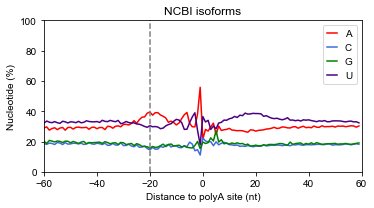

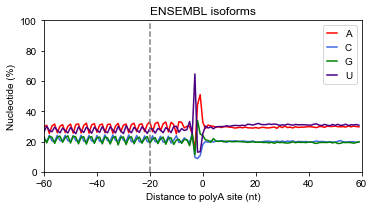

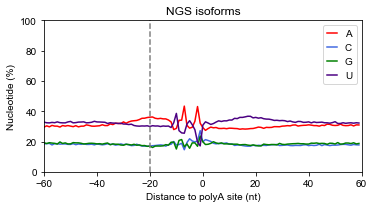

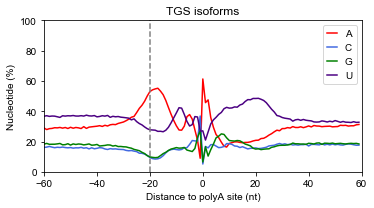

In [23]:
for name in ["ncbi", "ensembl", "ngs", "tgs"]:
    matrix = data[name]
    matrix = matrix[list(range(-60, 60))]
    xs = matrix.columns
    bases = ["A", "C", "G", "U", "N"]
    colors = ["red", "royalblue", "green", "indigo"]
    plt.figure(figsize=(5.3, 3))
    plt.title("%s isoforms" % name.upper())
    for j in range(4):
        ys = matrix.iloc[j]
        plt.plot(xs, ys * 100, color=colors[j], label=bases[j])
    plt.xlim(-60, 60)
    plt.ylim(0, 100)
    plt.axvline(-20, ls="--", color="grey")
    plt.xticks([-60, -40, -20, 0, 20, 40, 60])
    plt.xlabel("Distance to polyA site (nt)")
    plt.ylabel("Nucleotide (%)")
    plt.legend(handlelength=1)
    plt.tight_layout()
    plt.savefig("figures/polya_content.%s.pdf" % name, dpi=300)

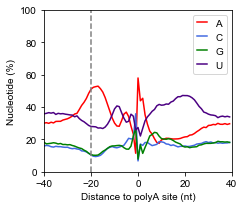

In [28]:
for name in ["asm"]:
    matrix = data[name]
    matrix = matrix[list(range(-40, 40))]
    xs = matrix.columns
    bases = ["A", "C", "G", "U", "N"]
    colors = ["red", "royalblue", "green", "indigo"]
    plt.figure(figsize=(3.5, 3))
    # plt.title("%s isoforms" % name.upper())
    for j in range(4):
        ys = matrix.iloc[j]
        plt.plot(xs, ys * 100, color=colors[j], label=bases[j])
    plt.xlim(-40, 40)
    plt.ylim(0, 100)
    plt.axvline(-20, ls="--", color="grey")
    plt.xticks([-40, -20, 0, 20, 40])
    plt.xlabel("Distance to polyA site (nt)")
    plt.ylabel("Nucleotide (%)")
    plt.legend(handlelength=1)
    plt.tight_layout()
    plt.savefig("figures/polya_content.%s.pdf" % name, dpi=300)

# Fraquency of polyA motif

In [31]:
def get_polya_sequences(path):
    with GtfFile(path) as f:
        transcripts = list(GtfTranscriptBuilder(f))
    seqs = []
    with FastaFile(f_fasta) as fasta:
        for transcript in transcripts:
            if len(transcript) < 200:
                continue
            if transcript.chrom == "NC_016870.1":
                continue
            if transcript.strand == "+":
                start = transcript.end - 100
            else:
                start = transcript.start - 100
            end = start + 200
            if start < 0:
                continue
            seq = fasta.fetch(chrom=transcript.chrom, start=start, end=end, strand=transcript.strand).upper()
            if len(seq) != 200:
                continue
            seqs.append(seq)
    return seqs
seqs1 = get_polya_sequences(f_gtf_ncbi)
seqs2 = get_polya_sequences(f_gtf_asm)

In [32]:
motifs = ["AATAAA", "ATTAAA", "TATAAA", "AGTAAA", 
          "AATACA", "CATAAA", "AATATA", "GATAAA", 
          "AATGAA", "AAGAAA", "ACTAAA", "AATAGA", 
          "AATAAT", "AACAAA", "ATTACA", "ATTATA"]

def get_motif_frequency(seqs, motif):
    ys = np.zeros(len(seqs[0]))
    for seq in seqs:
        for i in range(0, len(seq)):
            j = i + len(motif)
            if j > len(seq):
                break
            if seq[i:j] == motif:
                ys[i] += 1    
    ys = ys * 100 / len(seqs)
    return ys

array = []
for motif in motifs:
    ys1 = get_motif_frequency(seqs1, motif)
    ys2 = get_motif_frequency(seqs2, motif)
    array.append([ys1, ys2])

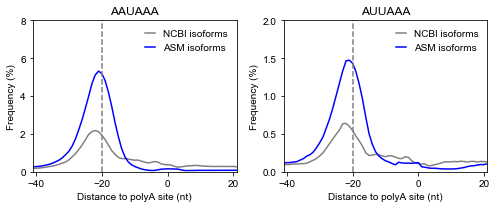

In [40]:
def smooth(xs, ys):
    return xs, scipy.signal.savgol_filter(ys, 7, 1)

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True)

plt.sca(axs[0])
xs = np.arange(-100, 100)
ys1 = array[0][0]
ys2 = array[0][1]
xs, ys1 = smooth(xs, ys1)
xs, ys2 = smooth(xs, ys2) 
motif = motifs[0]
plt.title(motif.replace("T", "U"))
plt.plot(xs, ys1, color="grey", label="NCBI isoforms")
plt.plot(xs, ys2, color="blue", label="ASM isoforms")
plt.axvline(-20, color="grey", ls="--")
plt.xlim(-41, 21)
plt.ylim(0, 8)
plt.xlabel("Distance to polyA site (nt)")
plt.ylabel("Frequency (%)")
plt.legend(frameon=False, handlelength=1)
plt.tight_layout()

plt.sca(axs[1])
xs = np.arange(-100, 100)
ys1 = array[1][0]
ys2 = array[1][1]
xs, ys1 = smooth(xs, ys1)
xs, ys2 = smooth(xs, ys2) 
motif = motifs[1]
plt.title(motif.replace("T", "U"))
plt.plot(xs, ys1, color="grey", label="NCBI isoforms")
plt.plot(xs, ys2, color="blue", label="ASM isoforms")
plt.axvline(-20, color="grey", ls="--")
plt.xlim(-41, 21)
plt.ylim(0, 2)
plt.xlabel("Distance to polyA site (nt)")
plt.ylabel("Frequency (%)")
plt.legend(frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("figures/polya_motif.freq.pdf", dpi=300)

# Plot APA gene count (bar)

In [41]:
def load_apa_distance(path):
    pas_motifs = ["AATAAA", "ATTAAA", "TATAAA", "AGTAAA", 
                  "AATACA", "CATAAA", "AATATA", "GATAAA", 
                  "AATGAA", "AAGAAA", "ACTAAA", "AATAGA", 
                  "AATAAT", "AACAAA", "ATTACA", "ATTATA"]
    
    with GtfFile(path) as f:
        records = [r for r in f]
    genes = list(GtfGeneBuilder(records))
    
    vs = []
    f = FastaFile(f_fasta)
    for g in genes:
        if len(g.transcripts) == 1:
            continue
        positions = []
        for t in g.transcripts:
            if len(t) < 200:
                continue
            if t.strand == "+":
                start, end = t.end - 40, t.end
                p = t.end
            else:
                start, end = t.start, t.start + 40
                p = t.start
            seq = f.fetch(chrom=t.chrom, start=start, end=end, strand=t.strand).upper()
            valid = False
            for m in pas_motifs:
                if m in seq:
                    valid = True
                    break
            if valid:
                positions.append(p)
        if len(positions) >= 2:
            d = max(positions) - min(positions)
            vs.append(d)
    return vs

vs1 = load_apa_distance(f_gtf_ncbi)
vs2 = load_apa_distance(f_gtf_ensembl)
vs3 = load_apa_distance(f_gtf_ngs)
vs4 = load_apa_distance(f_gtf_tgs)
vs5 = load_apa_distance(f_gtf_asm)
array = [vs1, vs2, vs3, vs4, vs5]

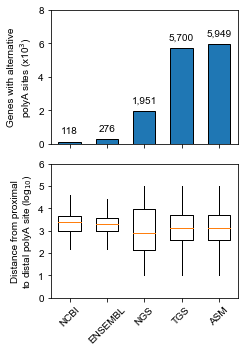

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 5), sharex=True)

plt.sca(axs[0])
ys = []
for vs in array:
    n = 0
    for v in vs:
        if 100 <= v <= 10000:
            n += 1
    ys.append(n)
xs = np.arange(len(ys))
ys = np.array(ys) / 1e3
plt.ylim(0, 8)
plt.bar(xs, ys, color="C0", width=0.6, edgecolor="black")
for x, y in zip(xs, ys):
    plt.text(x, y + 0.5, format(int(y*1000), ","), ha="center")
plt.ylabel("Genes with alternative\npolyA sites (x10$^3$)")
plt.tight_layout()

plt.sca(axs[1])
for x, ys in zip(xs, array):
    ys = np.array(ys)
    ys = ys[ys >= 10]
    ys = ys[ys < 100000]
    ys = np.log10(ys)
    plt.boxplot(ys, positions=[x], widths=0.6, showcaps=False, showfliers=False)
plt.xticks(xs, ["NCBI", "ENSEMBL", "NGS", "TGS", "ASM"], rotation=45)
plt.ylim(0, 6)
plt.ylabel("Distance from proximal\nto distal polyA site (log$_{10}$)")
plt.tight_layout()

plt.savefig("figures/APA_count.pdf", dpi=300)

# GnRHR2在垂体中的PolyA位点的鉴定

In [3]:
def load_transcripts(path):
    data = dict()
    with GtfFile(path) as f:
        for gene in GtfGeneBuilder(f):
            for transcript in gene.transcripts:
                data[transcript.name] = transcript
    return data
transcripts_ncbi = load_transcripts(f_gtf_ncbi)
transcripts_ensembl = load_transcripts(f_gtf_ensembl)
transcripts_asm = load_transcripts(f_gtf_asm)

In [4]:
transcript1 = transcripts_ensembl["ENSSDUT00000005875"]
transcript2 = transcripts_ncbi["XM_022740281.1"]
transcript3 = transcripts_asm["G610.2"]
transcripts = [transcript1, transcript2, transcript3]

In [5]:
chrom = "NW_019174258.1"
start = 6802500
end = 6808500
strand = "-"

paths = [
    "../../1_analysis_of_rna_seq/results/tracks/bw/Ad_Pi_Ma_1.norm.-.bw",
    "../../1_analysis_of_rna_seq/results/tracks/bw/Ad_Pi_Ma_2.norm.-.bw",
    "../../1_analysis_of_rna_seq/results/tracks/bw/Ad_Pi_Fe_1.norm.-.bw",
    "../../1_analysis_of_rna_seq/results/tracks/bw/Ad_Pi_Fe_2.norm.-.bw"]
array = []
for path in paths:
    with pyBigWig.open(path) as bw:
        values = bw.values(chrom, start, end)
        values = np.nan_to_num(values, 0)
        array.append(values)

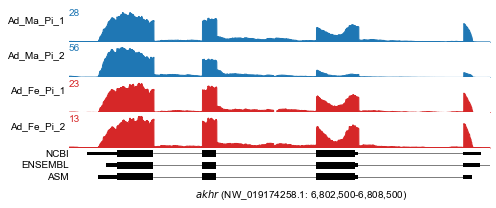

In [6]:
xs = np.arange(start, end)

fig, axs = plt.subplots(5, 1, figsize=(7, 3), sharex=True, gridspec_kw={"hspace": 0})

for i in range(5):
    ax = axs[i]
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
labels = ["Ad_Ma_Pi_1", "Ad_Ma_Pi_2", "Ad_Fe_Pi_1", "Ad_Fe_Pi_2"]
for i in range(len(array)):
    ax = axs[i]
    plt.sca(ax)
    ys = array[i]
    color = "C0" if i < 2 else "C3"
    plt.fill_between(xs, ys, color=color)
    h = int(max(ys) * 1.2)
    plt.ylim(0, h)
    # plt.text(start, 0, "0", va="bottom")
    plt.text(start, h * 0.95, "%s" % format(h, ","), va="top", color=color)
    plt.ylabel(labels[i], rotation=0, ha="right")
    plt.tight_layout()
    
plt.sca(axs[4])
plt.xlabel("\t\t$\it{akhr}$ (%s: %s-%s)" % (chrom, format(start, ","), format(end, ",")))
labels = ["NCBI", "ENSEMBL", "ASM"]
for i in range(len(transcripts)):
    transcript = transcripts[i]
    blocks = transcript.blocks
    if len(blocks) > 1:
        plt.plot([blocks[0][1], blocks[-1][0]], [i + 0.5, i + 0.5], ls="-", lw=0.5, color="black")
    for block_start, block_end in transcript.blocks:
        position = (block_start + block_end) / 2
        width = block_end - block_start
        plt.bar(position, 0.3, width=width, bottom=i + 0.35, color="black")
    if transcript.thick:
        thick_start, thick_end = transcript.thick
        for block_start, block_end in transcript.blocks:
            block_start = max(block_start, thick_start)
            block_end = min(block_end, thick_end)
            if block_start >= block_end:
                continue
            position = (block_start + block_end) / 2
            width = block_end - block_start
            plt.bar(position, 0.6, width=width, bottom=i + 0.2, color="black")
    plt.xlim(start, end)
    plt.text(start, i + 0.5, labels[i], ha="right", va="center")
plt.ylim(len(transcripts), 0)

plt.tight_layout()
plt.savefig("figures/track.ahkr.pdf", dpi=300)